# Evaluation

In [742]:
from collections import defaultdict
import polars as pl

results_checkov = pl.read_json(f'results/checkov_1721775655.json')
results_tflint = pl.read_json(f'results/tflint_1721775655.json')

In [743]:
CHECKOV_PATTERNS = [
    'Object storage lifecycle rules',
    'Old generation',
    'AWS - Expensive DynamoDB',
]

TFLINT_PATTERNS = [
    'Budget',
    'Object storage lifecycle rules',
    'Old generation',
    'AWS - Expensive DynamoDB',
]

## Precision/recall

### Checkov

#### Before

In [744]:
checkov_clean = results_checkov.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, _, _ in checkov_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false positive:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

----------
false positive: https://github.com/alphagov/govuk-aws/commit/6cfda6ada5137b232ff442ae9f2aedc8520ee1b4
commit: 7ec1573417fff41cae5b2081b007447e7a432789
real: Old generation
matched: ['Object storage lifecycle rules', 'Old generation']
Old generation - [195, 209] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-apt/main.tf
Old generation - [205, 219] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-deploy/main.tf
Old generation - [131, 145] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-logs-cdn/main.tf


In [745]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern'))

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 3   ┆ 24  ┆ 0   ┆ 0.111111  ┆ 1.0      │
│ Old generation                 ┆ 31  ┆ 16  ┆ 4   ┆ 15  ┆ 0.8       ┆ 0.516129 │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 23  ┆ 5   ┆ 0   ┆ 0.821429  ┆ 1.0      │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [746]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after, _ in checkov_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [747]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

summary = counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')

print(summary)

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 3   ┆ 48  ┆ 0   ┆ 0.058824  ┆ 1.0      │
│ Old generation                 ┆ 31  ┆ 16  ┆ 17  ┆ 15  ┆ 0.484848  ┆ 0.516129 │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 23  ┆ 20  ┆ 0   ┆ 0.534884  ┆ 1.0      │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### TFLint

#### Before

In [748]:
tflint_clean = results_tflint.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, _, _ in tflint_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false negative:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

----------
false negative: https://github.com/nsbno/terraform-aws-cost-alarm/commit/7e135499d33f0a5c51602a506fefe258cac072c6
commit: a7890d10b370fb97fe57a18f7d1bfeedc49f99ae
real: Budget
matched: []
----------
false positive: https://github.com/64kramsystem/ultimate_aws_certified_cloud_practitioner_course_terraform_configuration/commit/2f36b8a5f2f818138da72d218c1f3c9666ed54aa
commit: 12b334b4a5eab43610932a844948d0eaba5267f3
real: Budget
matched: ['Old generation', 'Old generation', 'Old generation', 'Object storage lifecycle rules', 'Object storage lifecycle rules', 'Budget']
Old generation - start: {'line': 3, 'column': 3} end: {'line': 3, 'column': 29} - snapshots/64kramsystem-ultimate_aws_certified_cloud_practitioner_course_terraform_configuration-2f36b8a5f2f818138da72d218c1f3c9666ed54aa/before-12b334b4a5eab43610932a844948d0eaba5267f3/terraform/ec2_instances.london.tf
Old generation - start: {'line': 35, 'column': 3} end: {'line': 35, 'column': 29} - snapshots/64kramsystem-ultimate_

In [749]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 7   ┆ 15  ┆ 8   ┆ 0.318182  ┆ 0.466667 │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 12  ┆ 0   ┆ 0.142857  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 3   ┆ 4   ┆ 0.666667  ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 0   ┆ 1   ┆ 1.0       ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [750]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after, _ in tflint_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [751]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 7   ┆ 40  ┆ 8   ┆ 0.148936  ┆ 0.466667 │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 24  ┆ 0   ┆ 0.076923  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 9   ┆ 4   ┆ 0.4       ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 3   ┆ 1   ┆ 0.8125    ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### Checkov + TFLint - Latest commits

In [752]:
latest_matches = defaultdict(lambda: defaultdict(int))

for (latest,) in checkov_clean.select('latest').filter(pl.col('latest').is_not_null()).iter_rows():
    for m in set(latest['matched']):
        latest_matches[m]['checkov'] += 1

for (latest,) in tflint_clean.select('latest').filter(pl.col('latest').is_not_null()).iter_rows():
    for m in set(latest['matched']):
        latest_matches[m]['tflint'] += 1


print(pl.DataFrame([
    {
        'pattern': pat,
        'checkov': row['checkov'],
        'tflint': row['tflint'],
    }
    for pat, row in latest_matches.items()
]))

shape: (4, 3)
┌────────────────────────────────┬─────────┬────────┐
│ pattern                        ┆ checkov ┆ tflint │
│ ---                            ┆ ---     ┆ ---    │
│ str                            ┆ i64     ┆ i64    │
╞════════════════════════════════╪═════════╪════════╡
│ Object storage lifecycle rules ┆ 26      ┆ 18     │
│ Old generation                 ┆ 6       ┆ 6      │
│ AWS - Expensive DynamoDB       ┆ 11      ┆ 5      │
│ Budget                         ┆ 0       ┆ 32     │
└────────────────────────────────┴─────────┴────────┘


## Performance

In [753]:
checkov_perf = {
    'before': results_checkov.select(duration=pl.col('before').list.get(0).struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    'after': results_checkov.select(duration=pl.col('after').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    # 'latest': results_checkov.select(duration=pl.col('latest').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
}

tflint_perf = {
    'before': results_tflint.select(duration=pl.col('before').list.get(0).struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    'after': results_tflint.select(duration=pl.col('after').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    # 'latest': results_tflint.select(duration=pl.col('latest').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
}

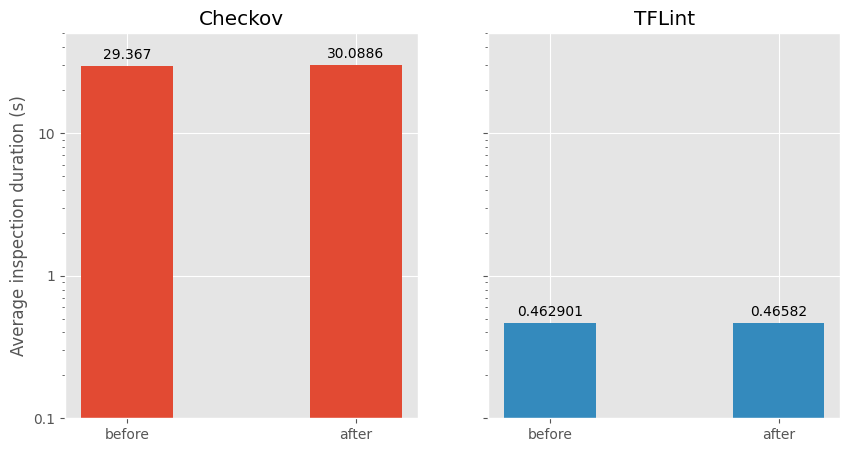

In [754]:
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

bar_data_checkov = [statistics.mean(v) for v in checkov_perf.values()]
bar_data_tflint = [statistics.mean(v) for v in tflint_perf.values()]

keys = list(checkov_perf.keys())
bar_width = 0.4
x1 = np.arange(len(checkov_perf))
x2 = np.arange(len(tflint_perf)) + len(checkov_perf) + bar_width

bars1 = ax1.bar(x1, bar_data_checkov, bar_width, label='Checkov')
ax1.bar_label(bars1, padding=3)
ax1.set_title('Checkov')
ax1.set_xticks(x1)
ax1.set_xticklabels(keys)
ax1.set_ylabel('Average inspection duration (s)')
ax1.set_yscale('log')
ax1.set_ylim(10**-1, 10**1.7)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

bars2 = ax2.bar(x2, bar_data_tflint, bar_width, label='TFLint', color='#348abd')
ax2.bar_label(bars2, padding=3)
ax2.set_title('TFLint')
ax2.set_xticks(x2)
ax2.set_xticklabels(keys)
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.show()

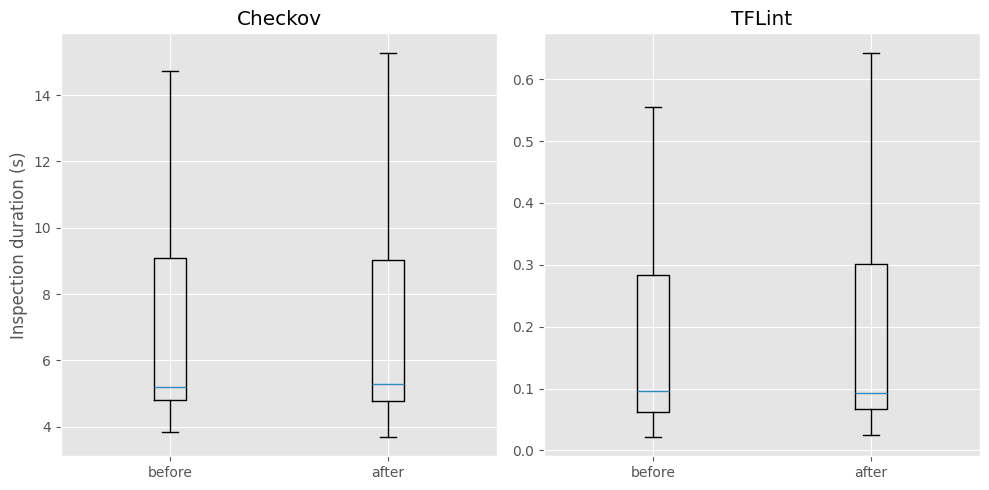

In [755]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

keys = list(checkov_perf.keys())

ax1.boxplot(list(checkov_perf.values()), showfliers=False)
ax1.set_title('Checkov')
ax1.set_xticklabels(keys)
ax1.set_ylabel('Inspection duration (s)')

ax2.boxplot(list(tflint_perf.values()), showfliers=False)
ax2.set_title('TFLint')
ax2.set_xticklabels(keys)

plt.tight_layout()
plt.show()